In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from collections import Counter
import os

root = "/kaggle/input/animal-image-classification-dataset/Animals"
counts = {label: len(os.listdir(os.path.join(root, label))) for label in ['cats', 'dogs', 'snakes']}
print(counts)

{'cats': 1000, 'dogs': 1000, 'snakes': 1000}


In [2]:
!pip install transformers timm pandas scikit-learn matplotlib seaborn tqdm --quiet

import os
import time
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import ViTImageProcessor, ViTModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00:00:0100:01


2025-06-10 09:11:32.149491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749546692.348023      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749546692.406437      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class Config:
    data_root = Path("/kaggle/input/animal-image-classification-dataset/Animals")
    model_name = "google/vit-base-patch16-224"
    grid_size = 2
    img_size = 224
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {Config.device}, Grid Size: {Config.grid_size}")

Device: cuda, Grid Size: 2


In [4]:
processor = ViTImageProcessor.from_pretrained(Config.model_name)
model = ViTModel.from_pretrained(Config.model_name).to(Config.device)
model.eval()

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [5]:
def collect_image_paths():
    label_map = {'cats': 0, 'dogs': 1, 'snakes': 2}
    samples = []

    for class_name, label in label_map.items():
        folder = Config.data_root / class_name
        for path in folder.glob("*.jpg"):
            samples.append((path, label))

    random.shuffle(samples)
    return samples

samples = collect_image_paths()
print(f"Total images collected: {len(samples)}")

Total images collected: 3000


In [6]:
train_samples, test_samples = train_test_split(samples, test_size=0.3, random_state=42, stratify=[s[1] for s in samples])
print(f"Train: {len(train_samples)} | Test: {len(test_samples)}")

Train: 2100 | Test: 900


In [13]:
def extract_global_features(image):
    inputs = processor(image, return_tensors="pt").to(Config.device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0].cpu().numpy()

def extract_grid_features(image):
    w, h = image.size
    grid_size = Config.grid_size
    tile_w, tile_h = w // grid_size, h // grid_size
    features = []

    for i in range(grid_size):
        for j in range(grid_size):
            tile = image.crop((j * tile_w, i * tile_h, (j + 1) * tile_w, (i + 1) * tile_h))
            inputs = processor(tile, return_tensors="pt").to(Config.device)
            with torch.no_grad():
                outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0].cpu().numpy()
            features.append(cls_embedding)

    return np.concatenate(features, axis=1)

In [1]:
def process_dataset(samples, feature_fn, name="Dataset"):
    features, labels = [], []
    print(f"Processing {name} with {len(samples)} images...")
    for path, label in tqdm(samples):
        image = Image.open(path).convert('RGB')
        features.append(feature_fn(image))
        labels.append(label)
    return np.vstack(features), np.array(labels)

In [16]:
X_train_global, y_train = process_dataset(train_samples, extract_global_features, "Train Global")
X_test_global, y_test = process_dataset(test_samples, extract_global_features, "Test Global")
X_train_grid, _ = process_dataset(train_samples, extract_grid_features, "Train Grid")
X_test_grid, _ = process_dataset(test_samples, extract_grid_features, "Test Grid")

print("Feature dimensions:")
print(f"Global: {X_train_global.shape[1]}, Grid: {X_train_grid.shape[1]}")

Processing Train Global with 2100 images...


100%|██████████| 2100/2100 [00:41<00:00, 50.01it/s]


Processing Test Global with 900 images...


100%|██████████| 900/900 [00:17<00:00, 50.93it/s]


Processing Train Grid with 2100 images...


100%|██████████| 2100/2100 [02:01<00:00, 17.26it/s]


Processing Test Grid with 900 images...


100%|██████████| 900/900 [00:52<00:00, 17.24it/s]

Feature dimensions:
Global: 768, Grid: 3072


In [17]:
def train_and_evaluate(X_train, X_test, model_type='logistic'):
    model_name = "Logistic Regression" if model_type == 'logistic' else "Decision Tree"
    print(f"\nTraining {model_name}...")
    if model_type == 'logistic':
        clf = LogisticRegression(max_iter=1000)
    else:
        clf = DecisionTreeClassifier()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    return accuracy

results = {}
results['global_lr'] = train_and_evaluate(X_train_global, X_test_global, 'logistic')
results['global_tree'] = train_and_evaluate(X_train_global, X_test_global, 'tree')
results['grid_lr'] = train_and_evaluate(X_train_grid, X_test_grid, 'logistic')
results['grid_tree'] = train_and_evaluate(X_train_grid, X_test_grid, 'tree')


Training Logistic Regression...
Logistic Regression Accuracy: 0.9967

Training Decision Tree...
Decision Tree Accuracy: 0.9522

Training Logistic Regression...
Logistic Regression Accuracy: 0.9978

Training Decision Tree...
Decision Tree Accuracy: 0.9156


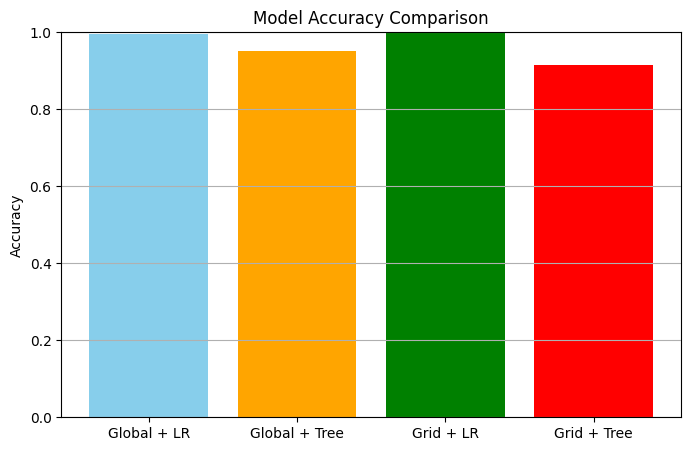

In [18]:
labels = ['Global + LR', 'Global + Tree', 'Grid + LR', 'Grid + Tree']
accuracies = [results[k] for k in results]

plt.figure(figsize=(8,5))
plt.title("Model Accuracy Comparison")
plt.bar(labels, accuracies, color=['skyblue', 'orange', 'green', 'red'])
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


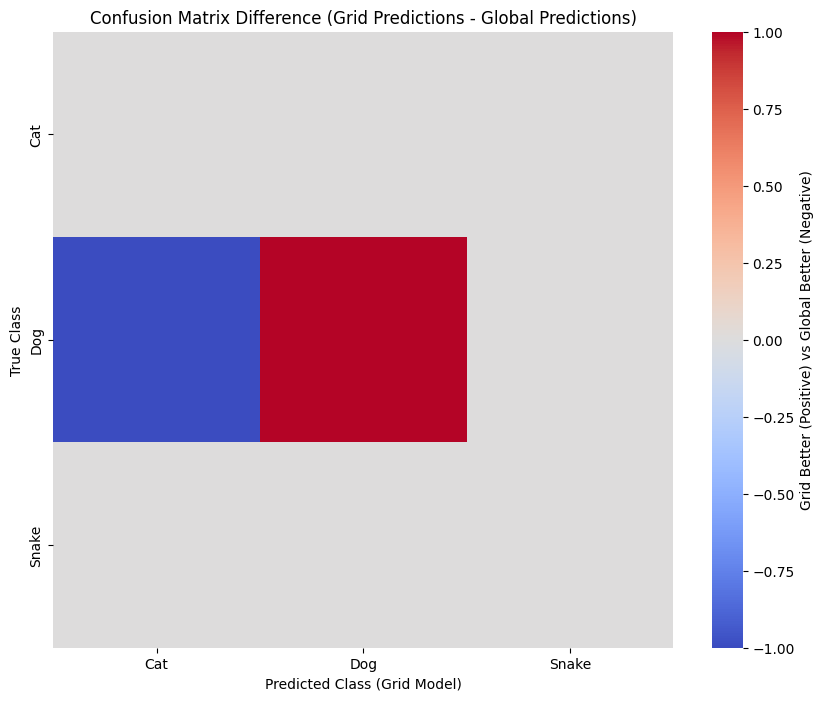

In [36]:
plt.figure(figsize=(10,8))
cm_global = confusion_matrix(y_test, y_pred_global)
cm_grid = confusion_matrix(y_test, y_pred_grid)
cm_diff = cm_grid - cm_global 

sns.heatmap(cm_diff, cmap='coolwarm', center=0, 
            annot=False, cbar_kws={'label': 'Grid Better (Positive) vs Global Better (Negative)'})
plt.title("Confusion Matrix Difference (Grid Predictions - Global Predictions)")
plt.xlabel("Predicted Class (Grid Model)")
plt.ylabel("True Class")
plt.xticks(ticks=[0.5,1.5,2.5], labels=label_map.values())
plt.yticks(ticks=[0.5,1.5,2.5], labels=label_map.values())
plt.show()

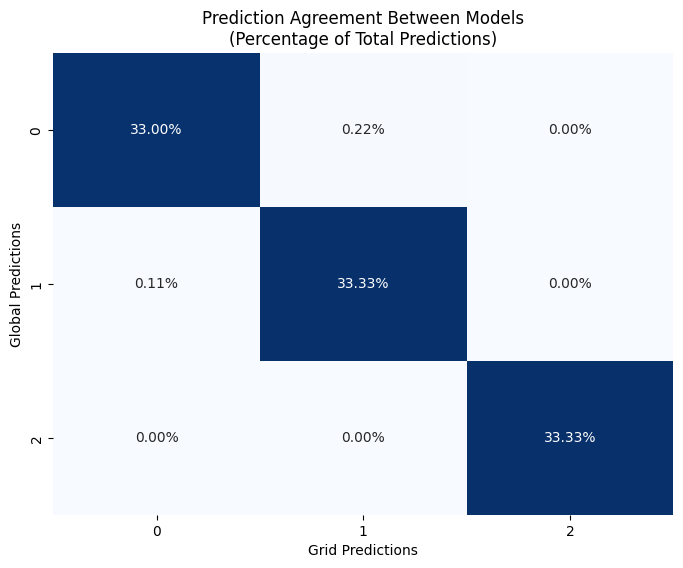

In [37]:
plt.figure(figsize=(8,6))
agreement = pd.crosstab(
    pd.Series(y_pred_global, name='Global Predictions'),
    pd.Series(y_pred_grid, name='Grid Predictions'),
    normalize='all'
)

sns.heatmap(agreement, annot=True, fmt=".2%", cmap='Blues', cbar=False)
plt.title("Prediction Agreement Between Models\n(Percentage of Total Predictions)")
plt.show()


🔍 Displaying predictions on test images...


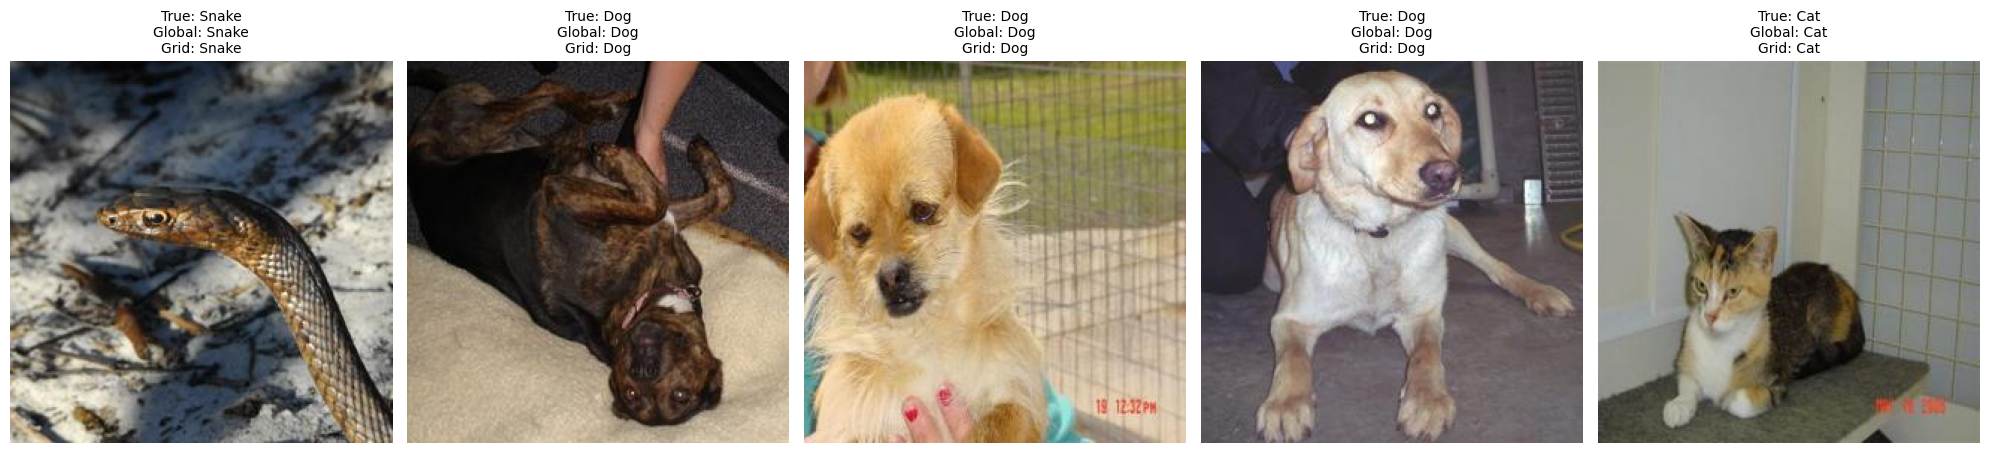

In [30]:
print("\n Displaying predictions on test images...")

y_pred_global = LogisticRegression(max_iter=1000).fit(X_train_global, y_train).predict(X_test_global)
y_pred_grid = LogisticRegression(max_iter=1000).fit(X_train_grid, y_train).predict(X_test_grid)

label_map = {0: 'Cat', 1: 'Dog', 2: 'Snake'}

num_samples = 5
indices = random.sample(range(len(test_samples)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i, idx in enumerate(indices):
    img_path, true_label = test_samples[idx]
    image = Image.open(img_path).convert("RGB")

    pred_global = y_pred_global[idx]
    pred_grid = y_pred_grid[idx]

    title = f"True: {label_map[true_label]}\nGlobal: {label_map[pred_global]}\nGrid: {label_map[pred_grid]}"
    axes[i].imshow(image)
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()